## Writing Finance Articles with Agentic Workflows
<link rel="stylesheet"
href="https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css"
integrity="sha384-JcKb8q3iqJ61gNV9KGb8thSsNjpSL0n8PARn9HuZOnIxN0hoP+VmmDGMN5t9UJ0Z"
crossorigin="anonymous">
<div class="bg-info">
<h3>What are agentic workflows?</h3>
</div>

An <b>agentic workflow</b> is a multi-step sequence of tasks or decisions whose orchestration is handled by AI agents. In Generative AI, AI agents are Large Language Models (or "Large Action Models" in this context) that can perform goal-oriented tasks with minimal human intervention. Such tasks may include everything from simple reasoning tasks to complex decision making, and often involve interaction with external resources or systems (called "tools").

The following will build an agentic workflow for writing finance articles. The workflow consists of the following steps:


1.   A **searcher** agent (LLM + search tool) which will search the web for relevant links based on user input.
2.   An **outliner** node (LLM) which will generate a suitable outline for the article.
3.   A **writer** node (LLM) which will generate the final article.
4.   A **critic** node (LLM) which will critique the writer's output and provide feedback to the **writer** for improvements.








<div class="bg-info">
<h3>What is the difference between an agentic framework and an agentic orchestration framework?</h3>
</div>

There are different schools of thought about agentic orchestration frameworks.

Agentic orchestration can refer to <b>agent-of-agent</b> systems, which are defined based on the number of agents. In this case, they are simply agentic systems that consist of more than a single agent. Hence, it can refer to agentic systems with multiple agents; it can also refer to agentic systems that invoke other agentic systems.

Sometimes, agentic orchestration can also be used to distinguish complex multi-agent systems from simpler agentic systems. In this case, agentic orchestration is only necessary for systems with high levels of complexity. This is based on not just the number of agents, but other factors such as the types of flows (directed versus cyclic).

There are many frameworks that can be used for building agentic workflows. Due to their reasoning and decision-making abilities, LLMs are a natural fit for driving autonomous workflows. However, users often want the ability to extend, constrain or even override aspects of the flow. For example, they may need a way to dynamically limit cycles, manage state across disparate tools, or integrate human-in-the-loop fedback. A popular approach is to use <b>LLM orchestration</b> frameworks. These are frameworks that combine the flexible and dynamic capabilities of agent-driven workflows with low-level control over essential details of the orchestration. This notebook uses <b>LangChain</b> to build the AI agents, and <b>LangGraph</b> to build the agentic workflow that orchestrates the agents.

# Setup

In [1]:
# Install dependencies
!pip install -qU langgraph langgraph langchain_openai langchain_community python-dotenv langchain_mistralai llamaapi langchain-experimental langgraph-checkpoint langgraph-checkpoint-sqlite;


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import libraries
import os
import httpx
from typing import TypedDict, Annotated, Literal, TypedDict
import functools
from IPython.display import Image
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

## Defining Templates
Each agent has its own specific **template**. The templates are defined here.

In [3]:
searcher_template = """
Your task is to search the web for news articles relevant to the user's request.

NOTE: Do not write the article. Simply search for and gather related news articles if needed, then forward them to the outliner node.
"""

outliner_template = """
Your task is to take a list of web articles and the user's instructions about the article they want to write, and use them to generate a concise outline.

Focus on organizing the main points clearly to guide the writing process.
"""

writer_template = """
Your task is to write an article using the following format:

    TITLE: <title>
    BODY: <body>

IMPORTANT: Do not copy the outline directly. Write the article in a clear and concise manner, with enough detail to inform the reader on the topic. Be sure to follow the outline.
```
"""

critic_template = """
Your task is to critique an article written by a writer. Provide constructive feedback that can help improve the article.

GUIDELINES:

  - Provide feedback in bullet point format only.
  - Focus on the use of keywords, the article title, and section headers. Ensure references are included.
  - Do NOT write or rewrite the article.
  - Do NOT include positive feedback.
  - Never accept the first draft as final.
  - If the article meets all expectations, respond with: DONE
"""

## Defining State
Here, we will define our **GraphState**, as well as the **nodes** and **edges** that our graph is comprised of. This will encapsulate **state** in our agentic workflows.

In [4]:
#####################################
## STATE ##
#####################################
class NMAgentState(TypedDict):
  """
  Encapsulates state in our agentic workflow
  """
  messages: Annotated[list, add_messages]

#####################################
## TOOLS ##
#####################################
google_search_tool = TavilySearchResults(max_results=5, include_answer=True, include_raw_content=True, include_images=True,)

#####################################
## AGENTS ##
#####################################
"""
The LLMs used by the agents
"""
granite_llm = ChatOpenAI(openai_api_base=os.environ["OPENAI_API_BASE"],
                         openai_api_key=os.environ["OPENAI_API_KEY"],
                         model=os.environ["OPENAI_API_MODEL"],
                         http_client=httpx.Client(verify=False),
                         temperature=0.3,
                         request_timeout=240)

def create_agent(llm, tools, system_message: str):
    """
    Creates an agent with the given LLM, tools, and system message
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

searcher_agent = create_agent(granite_llm, [google_search_tool], searcher_template)
outliner_agent = create_agent(granite_llm, [], outliner_template)
writer_agent = create_agent(granite_llm, [], writer_template)
critic_agent = create_agent(granite_llm, [], critic_template)

#####################################
## NODES ##
#####################################
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return { "messages": [result] }

searcher_node = functools.partial(agent_node, agent=searcher_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")
tool_node = ToolNode([google_search_tool])
critic_node = functools.partial(agent_node, agent=critic_agent, name="Critic Agent")

#####################################
## EDGES ##
#####################################
def should_search(state) -> Literal['tools', 'outliner']:
  if len(state['messages']) and state['messages'][-1].tool_calls:
    return "tools"
  else:
    return "outliner"

def should_edit(state) -> Literal['writer', END]:
  if len(state['messages']) and 'DONE' in state['messages'][-1].content:
    return END
  else:
    return "writer"

## Defining the Workflow Graph
Here, we will define the workflow, which will encapsulate the state, nodes and edges defined above.

In [5]:
workflow = StateGraph(NMAgentState)

# nodes
workflow.add_node("searcher", searcher_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)
workflow.add_node("tools", tool_node)
workflow.add_node("critic", critic_node)

# entrypoint
workflow.set_entry_point("searcher")

# edges
workflow.add_conditional_edges("searcher", should_search)
workflow.add_edge("tools", "searcher")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", 'critic')
workflow.add_conditional_edges("critic", should_edit)

# compile the workflow into a graph
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer, interrupt_before=['critic'])

Visualize the graph:

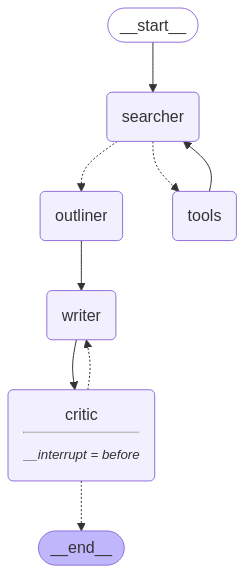

In [6]:
Image(graph.get_graph(xray=1).draw_mermaid_png())

# Testing the workflow
Now that the workflow has been generated, we can test it out with different prompts.

In [7]:
# Prompt to test
input = "Generate an article about net-zero alignment by Neuberger Berman."

In [8]:
config = {"configurable": {"thread_id": 12, "recursion_limit": 10}}
try:
  for event in graph.stream({"messages": [HumanMessage(content=input)]}, config, stream_mode="values"):
      event['messages'][-1].pretty_print()
except Exception as e:
  print(f"\n\nErrors generating response:\n===============\n {str(e)}")

================================ Human Message =================================

Generate an article about net-zero alignment by Neuberger Berman.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (chatcmpl-tool-0b8859ad58fc4a6daa4313b41ccff2e2)
 Call ID: chatcmpl-tool-0b8859ad58fc4a6daa4313b41ccff2e2
  Args:
    query: Neuberger Berman net-zero alignment
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "[PDF] Net-Zero Alignment: Beyond the Numbers - Neuberger Berman", "url": "https://www.nb.com/handlers/documents.ashx?id=45da7803-2a49-4ba0-bbc4-e164640bddb2", "content": "That is why we believe investors must make their own assessment of companies’ net-zero \nalignment, and why we think those assessments should be informed by fundamental-research \ncapabilities that can fill the gaps in the data with specialist, real-time insight. Neuberg